#JAX Fundamentals

####Reference:
https://jax.readthedocs.io/en/latest/notebooks/quickstart.html

###What is JAX?


*   JAX is NumPy on accelerator (CPU/GPU/TPU) with great automatic differentiation for high-performance machine learning research.
*   JAX can automatically differentiate native Python and NumPy code (it can even take derivatives of derivatives of derivatives) by the help of Autograd feature.
*   It supports reverse-mode as well as forward-mode differentiation, and the two can be composed arbitrarily to any order.
*   JAX even lets us just-in-time compile our own Python functions into XLA-optimized kernels using a one-function API.
*   JAX uses asynchronous dispatch to hide Python overheads.






###

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap, random   #We shouldn't import libraries like this , right? 

###Multiplying Matrices

In [2]:
key = random.PRNGKey(0)     #seed=0
x = random.normal(key,(10,))
x

DeviceArray([-0.3721109 ,  0.26423115, -0.18252768, -0.7368197 ,
             -0.44030377, -0.1521442 , -0.67135346, -0.5908641 ,
              0.73168886,  0.5673026 ], dtype=float32)

Note that it's a device array which means that it is device (accelerator) agnostic and hence immutable too.

In [3]:
#Example1:

size = 3000
x = random.normal(key, (size,size), dtype=jnp.float32)
%timeit multiplication = jnp.dot(x,x.T).block_until_ready()     #added block_until_ready() because JAX uses asynchronous execution by defaultblock_until_ready()


The slowest run took 232.82 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 7.19 ms per loop


Significance of block_unitl_ready()


*   It basically means wait until the operation is complete.
*   By default JAX runs everything asynchronously. Everytime we call an operation it gets queued up to the accelerator and then immediately returns control back to Python.





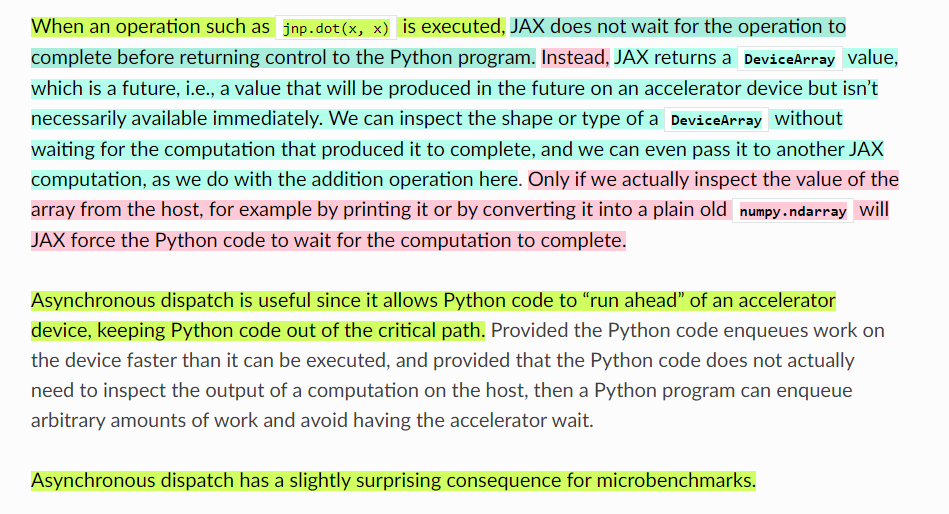

##JAX NumPy functions work on regular NumPy arrays.

In [4]:
import numpy as np
x_cpu = np.random.normal(size=(size, size)).astype(np.float32)
%timeit jnp.dot(x_cpu, x_cpu.T).block_until_ready()      #x_cpu (the data) is transferred to the GPU

10 loops, best of 5: 58.1 ms per loop


In [5]:
%timeit -n 1 -r 1 jnp.dot(x_cpu, x_cpu.T).block_until_ready()

1 loop, best of 1: 64.3 ms per loop


In [6]:
%timeit -n 5 -r 5 jnp.dot(x_cpu, x_cpu.T).block_until_ready()

5 loops, best of 5: 44.4 ms per loop


In [7]:
%timeit -n 1 -r 5 jnp.dot(x_cpu, x_cpu.T).block_until_ready()             #n-> number of loops, r-> number of runs?

1 loop, best of 5: 39 ms per loop


We can ensure that an NDArray is backed by device memory using device_put().

In [8]:
from jax import device_put

x_cpu = np.random.normal(size = (size,size)).astype(np.float32)
x_cpu = device_put(x_cpu)                                          #transferring x_cpu to the available device
%timeit jnp.dot(x_cpu,x_cpu.T).block_until_ready()

100 loops, best of 5: 7.15 ms per loop


Note - by the help of device_put() the processing time decreased a bit more!



To read more about device_put() operation follow this link - https://jax.readthedocs.io/en/latest/jax.html#jax.device_put 

JAX is much more than just a GPU-backed NumPy. It also comes with a few program transformations that are useful when writing numerical code. For now, there are three main ones:




*   jit(), for speeding up your code
*   grad(), for taking derivatives
*   vmap(), for automatic vectorization or batching.










#Using jit() to speed up functions 



* JAX runs transparently on the accelerator   

*   If we have a sequence of operations, we can use the @jit decorator to compile  multiple operations together using XLA



####🛑(Note that there are some constraints with using JIT) 

In [9]:
def selu(x, alpha=1.67, lmbda=1.05): 
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = random.normal(key,(1000000,))
%timeit selu(x).block_until_ready()

The slowest run took 273.45 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 1.45 ms per loop


We can speed it up by jit-ing!

In [14]:
%timeit -n 1 -r 5 jit(selu)(x).block_until_ready() 

1 loop, best of 5: 177 µs per loop


#Taking derivatives with grad()


In JAX, we can compute gradients with the grad() function.

In [18]:
def sum_logistic(x):
  return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)

%timeit -n 1 -r 5 grad(sum_logistic)(x_small)

1 loop, best of 5: 4.49 ms per loop


In [20]:
%timeit -n 1 -r 5 jit(grad(sum_logistic))(x_small)       #WHAT JUST HAPPENED HERE!?? Why jit-ed version took more time?

1 loop, best of 5: 56.2 ms per loop


In [21]:
print(grad(jit(grad(jit(grad(sum_logistic)))))(1.0))

-0.0353256


We can use jax.vjp() for reverse-mode vector-Jacobian products and jax.jvp() for forward-mode Jacobian-vector products.

In [25]:
from jax import jacfwd, jacrev
def hessian(fun):
  return jit(jacfwd(jacrev(fun)))

#Auto-vectorization with vmap()

What is VECTORIZATION?

Vectorization is a method of applying a function to all the elements of an array in one pass which in turn makes code much faster.

VMAP works alot like a regular Python map!

In [27]:
mat = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(v):
  return jnp.dot(mat, v)


#Given a function such as apply_matrix, we can loop over a batch dimension in Python, but usually the performance of doing so is poor.
def naively_batched_apply_matrix(v_batched):
  return jnp.stack([apply_matrix(v) for v in v_batched])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
100 loops, best of 5: 3.27 ms per loop


In [30]:
#Batching above operation manually using jnp.dot
#jnp.dot handles extra batch dimensions transparently.

mat = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(v):
  return jnp.dot(mat, v)

@jit
def batched_apply_matrix(v_batched):
  return jnp.dot(v_batched, mat.T)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
The slowest run took 143.44 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 63.2 µs per loop


In [31]:
#Better approach
#For a more complicated function without batching support we can use vmap() to add batching support automatically.

mat = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(v):
  return jnp.dot(mat, v)


@jit
def vmap_batched_apply_matrix(v_batched):
  return vmap(apply_matrix)(v_batched)

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
The slowest run took 1377.62 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 53.7 µs per loop


Note - vmap() can be arbitrarily composed with jit(), grad(), and any other JAX transformation.